In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

# 1. Задача классификации. Болезни сердца

In [2]:
heart = pd.read_csv('heart.csv')
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## 1.1 Логистическая регрессия

Бинаризуем категориальные небинарные переменные

In [3]:
categorical = ['cp', 'restecg', 'slope', 'ca', 'thal']
heart_bin = pd.get_dummies(heart, columns=categorical)

Масштабируем данные

In [4]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = StandardScaler()
heart_bin[numerical] = scaler.fit_transform(heart_bin[numerical])

Выполняем поиск лучшего коэффициента регуляризации

In [5]:
X_train, X_test, y_train, y_test = train_test_split(heart_bin.drop('target', axis=1), heart_bin.target, test_size=0.25, random_state=356) 

In [6]:
C = np.logspace(-3, 3, 50)
searcher = GridSearchCV(LogisticRegression(max_iter=1000), [{"C": C}], scoring="accuracy", cv=3)
searcher.fit(X_train, y_train)
best_C = searcher.best_params_["C"]

Обучаем модель с лучшим коэффициентом регуляризации, проверяем качество классификации на отложенной выборке

In [7]:
logreg = LogisticRegression(max_iter=1000, C=best_C)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

0.7631578947368421

## 1.2 Градиентный бустинг
СatBoost почти не нуждается в предобработке данных

In [8]:
X_train, X_test, y_train, y_test = train_test_split(heart.drop('target', axis=1), heart.target, test_size=0.25, random_state=619) 

categorical = ['cp', 'restecg', 'slope', 'ca', 'thal', 'sex', 'fbs','exang']
ctb = CatBoostClassifier(cat_features=categorical, silent=True, eval_metric='Accuracy')
ctb.fit(X_train, y_train)
y_pred = ctb.predict(X_test)
accuracy_score(y_test, y_pred)

0.8947368421052632

Заметно, что качество классификации градиентного бустинга без какого-либо подбора оптимальных параметров выше, чем качество логистической регрессии с подобранным параметром $\mathcal{l}_2$ -регуляризации

# 2. Задача регрессии. Ценообразование недвижимости

In [9]:
train = pd.read_csv('~/.kaggle/train.csv', index_col=0)
test = pd.read_csv('~/.kaggle/test.csv', index_col=0)
train.SalePrice = np.log1p(train.SalePrice) #т.к. используется метрика RMSLE
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133


## 2.1 Логистическая регрессия
Осуществим предобработку данных (заполним отсутствующие значения, закодируем категориальные переменные)

In [10]:
numerical = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
             'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
categorical = train.drop(numerical, axis=1).drop('SalePrice', axis=1).columns
categorical

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
train[categorical] = train[categorical].fillna('NotGiven')
test[categorical] = test[categorical].fillna('NotGiven')

In [12]:
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dataset_dum = pd.get_dummies(dataset, columns=categorical)
train_dum = dataset_dum[:train_objs_num]
test_dum = dataset_dum[train_objs_num:]

In [13]:
X_train, X_val, y_train, y_val = train_test_split(train_dum.drop('SalePrice', axis=1), train_dum.SalePrice, test_size=0.25, random_state=42)

In [14]:
numeric_data = X_train[numerical]
numeric_data_median = numeric_data.median()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_median)
X_val = X_val.fillna(numeric_data_median)

Масштабируем данные

In [15]:
scaler = StandardScaler()
scaler.fit(X_train[numerical])
X_train[numerical] = scaler.transform(X_train[numerical])
X_val[numerical] = scaler.transform(X_val[numerical])

Выберем оптимальный коэффициент регуляризации

In [16]:
alpha = np.logspace(-3, 3, 100)
searcher = GridSearchCV(Ridge(max_iter=1000), [{"alpha": alpha}], scoring="neg_root_mean_squared_error", cv=3)
searcher.fit(X_train, y_train)
best_alpha = searcher.best_params_["alpha"]

Обучим модель с оптимальным коэффициентом регуляризации

In [17]:
model = Ridge(max_iter=1000, alpha=best_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

0.13748253362426197

Рассмотрим 20 признаков с наибольшими по модулю коэффициентами. Заметно, что здесь за счет бинаризации категориальных переменных их значения учитываются по отдельности. Это, с одной стороны, помогает сравнить важность различных значений одного признака, но, с другой стороны, загромождает общую картину важности признаков для целевой переменной. 

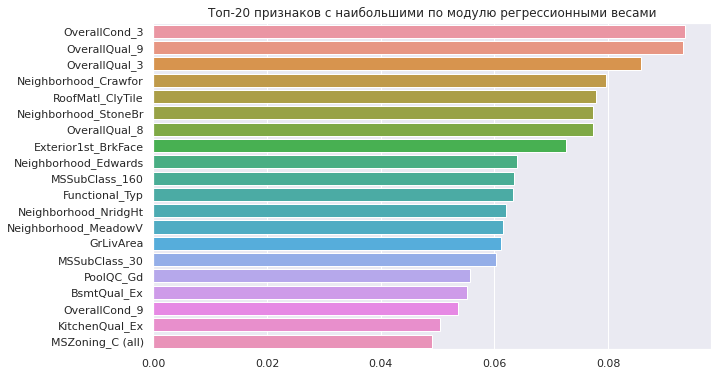

In [18]:
features = model.feature_names_in_[np.argsort(abs(model.coef_))[::-1]]
weights = np.sort(abs(model.coef_))[::-1]
sns.set(rc={'figure.figsize':(10,6)})
sns.barplot(x=weights[:20], y=features[:20]).set_title('Топ-20 признаков c наибольшими по модулю регрессионными весами');

Два района Crawford и Stone Brook (признак Neighborhood), судя по всему, самые престижные в Эймсе.  
Сразу же видно несколько аномалий: оценка 3 условий проживания (OverallCond) влияет на цену больше, чем оценка 9, а оценка 3 качества ремонта и материалов (OverallQual) больше, чем оценка 8. В этом недостаток бинаризации категориальных признаков

## 2.2 Градиентный бустинг
Часть обучающей выборки возьмем в качестве валидационной, чтобы контролировать переобучение  
Проверка качества модели будет осуществляться с помощью тестовой выборки, ответы для которой не публично хранятся на kaggle

In [19]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('SalePrice', axis=1), train.SalePrice, test_size=0.25, random_state=42)

In [20]:
train_pool = Pool(X_train, label=y_train, cat_features=np.array(categorical))
val_pool = Pool(X_val, label=y_val, cat_features=np.array(categorical))
test_pool = Pool(test, cat_features=np.array(categorical))

Обучим модель без явного задания параметров, это будет опорный результат, который мы будем стремиться улучшить

In [21]:
ctb_model = CatBoostRegressor()

ctb_model.fit(train_pool, eval_set=val_pool, plot=True, verbose=False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сформируем .csv файл и загрузим его на kaggle для оценки точности на тестовой выборке

In [22]:
y_submit = ctb_model.predict(test_pool)
submit_dflt_params = pd.DataFrame({'Id':test.index, 'SalePrice': np.expm1(y_submit)})
submit_dflt_params.to_csv('~/ds/house_prices/submit_dflt_params.csv', index=False)

0.12948 - RMSLE на тестовой выборке

Качество предсказания "из коробки" уже сейчас выше, чем у Ridge-регрессии, изучим параметры

In [23]:
base_params = ctb_model.get_all_params()
base_params

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCou

Оптимизируем параметры: число итераций (iterations), максимальную глубину деревьев (depth), коэффициент $\mathcal{l}_2$-регуляризации (l2_leaf_reg) и темп обучения или градиентный шаг (learning_rate)

In [24]:
base_learning_rate = base_params['learning_rate']
base_depth = base_params['depth']
base_l2_leaf_reg =  base_params['l2_leaf_reg']
base_iterations = base_params['iterations']

Выполняем поиск оптимальных параметров по сетке

In [25]:
grid = {'iterations' : np.array([1, 4, 8]) * base_iterations,
        'learning_rate': np.array([1, 0.1, 0.05]) * base_learning_rate,
        'depth': np.array([2/3, 1, 4/3]) * base_depth,
        'l2_leaf_reg': np.array([1/3, 1]) * base_l2_leaf_reg}

params_grid = {'eval_metric' : 'RMSE',
               'early_stopping_rounds' : 300,
               'random_seed' : 42,
               'logging_level' : 'Silent'}

ctb = CatBoostRegressor(**params_grid)
randomized_search_results = ctb.randomized_search(grid, X = train_pool, verbose=False, n_iter=15)
best_params = randomized_search_results['params']

In [26]:
best_model = CatBoostRegressor(**best_params)
best_model.fit(train_pool, eval_set=val_pool, plot=True, verbose=False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сделаем прогноз на тестовых данных и сформируем .csv файл с ответами для загрузки на Kaggle

In [27]:
y_submit = best_model.predict(test_pool)
submit_best = pd.DataFrame({'Id':test.index, 'SalePrice': np.expm1(y_submit)})
submit_best.to_csv('~/ds/house_prices/submit_best.csv', index=False)

0.12420 - RMSLE на тестовой выборке   
Подбор гиперпараметров позволил улучшить качество на ~5% 

Сохраним модель, чтобы в будущем для ее использования не приходилось каждый раз осуществлять поиск параметров

In [28]:
best_model.save_model('house_prices')

Загрузим модель, если ее имя сейчас не определено в окружении (если на текущем запуске ядра Python не искали параметры по сетке)

In [29]:
if 'best_model' not in globals():
    best_model = CatBoostRegressor()
    best_model.load_model('house_prices')

Важным преимуществом деревьев является их интерпретируемость для человека   
Изучим важность признаков

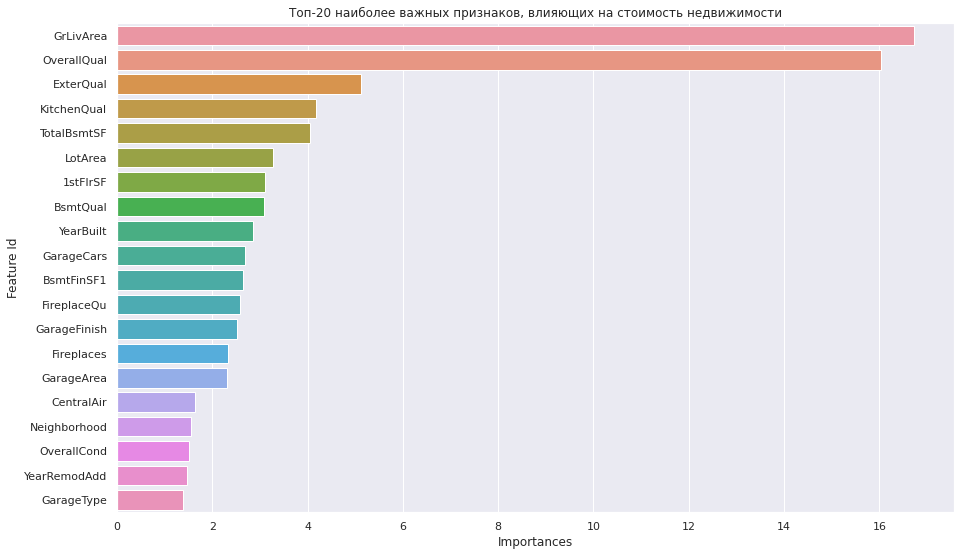

In [30]:
fe_imp = best_model.get_feature_importance(prettified=True)
sns.set(rc={'figure.figsize':(15,9)})
sns.barplot(y = 'Feature Id', x = 'Importances', data=fe_imp[:20]).set_title('Топ-20 наиболее важных признаков, влияющих на стоимость недвижимости'); 

Наибольшую с отрывом важность имеют жилая площадь недвижимости (GrLivArea) и оценка качества ремонта и материлов дома (OverallQual)  

Так же, высокую важность для цены имеют качество внешней отделки дома, кухня, камины (количество и качество), гараж (вместимость, количество, качество), участок, район   

Из интересного: высокую важность имеет площадь подвала, возможно, это объясняется тем, что она зачастую коррелирует с площадью всего дома   

Качество стройматериалов (дорогие, дешевые) (OverallQual) имеет больший вес, чем их состояние, износ (OverallCond), что тоже логично, т.к зачастую не только в строительстве и недвижимости качественные, хоть и не в идеальном состоянии, материалы ценятся больше, чем дешевые в идеальном состоянии 

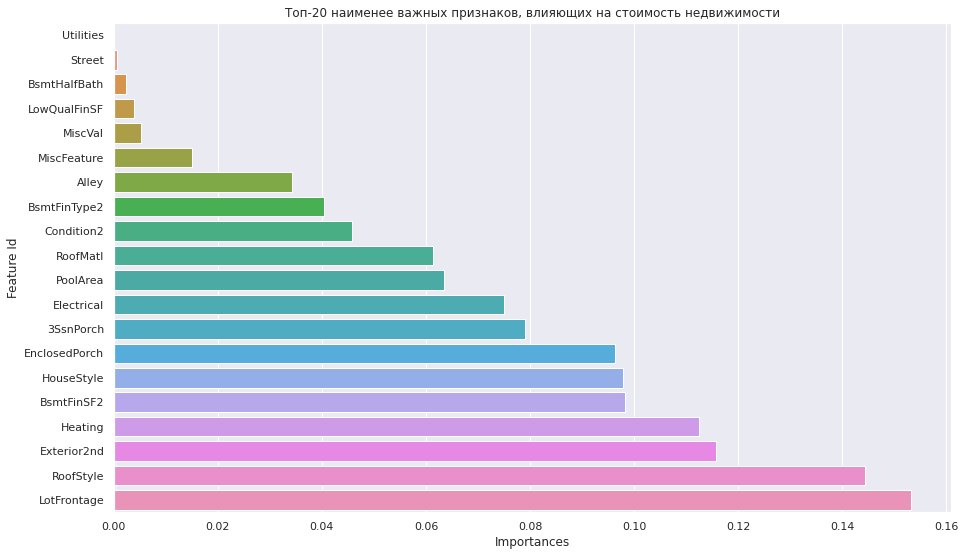

In [31]:
sns.barplot(y = 'Feature Id', x = 'Importances', 
            data = fe_imp.sort_values(by = 'Importances')[:20]).set_title('Топ-20 наименее важных признаков, влияющих на стоимость недвижимости'); 

Сразу бросается в глаза нулевой вес признака доступные коммунальные услуги (Utilities), посмотрим, какие значения он принимает:

In [62]:
train.Utilities.value_counts(), test.Utilities.value_counts()

(AllPub    1459
 NoSeWa       1
 Name: Utilities, dtype: int64,
 AllPub      1457
 NotGiven       2
 Name: Utilities, dtype: int64)

И в обучающей, и в тестовой выборке это признак по сути константный и не влияет на результат, поэтому CatBoost его обнулил

Такая же ситуация наблюдается с типом дороги, ведущей к участку (Street) и аллеи, ведущей от дороги к участку (Alley)

In [61]:
train.Street.value_counts(), test.Street.value_counts()

(Pave    1454
 Grvl       6
 Name: Street, dtype: int64,
 Pave    1453
 Grvl       6
 Name: Street, dtype: int64)

In [69]:
train.Alley.value_counts(), test.Alley.value_counts()

(NotGiven    1369
 Grvl          50
 Pave          41
 Name: Alley, dtype: int64,
 NotGiven    1352
 Grvl          70
 Pave          37
 Name: Alley, dtype: int64)

Низким вкладом в цену также обладают:  
- Стиль дома и крыши
- Площадь бассейна (большим вкладом обладает его наличие, а площадь уже вторична)
- Площадь крыльца
- Тип отопления и тип электрической проводки